# 第8章 提升方法

1．提升方法是将弱学习算法提升为强学习算法的统计学习方法。在分类学习中，提升方法通过反复修改训练数据的权值分布，构建一系列基本分类器（弱分类器），并将这些基本分类器线性组合，构成一个强分类器。代表性的提升方法是AdaBoost算法。

AdaBoost模型是弱分类器的线性组合：

$$f(x)=\sum_{m=1}^{M} \alpha_{m} G_{m}(x)$$

2．AdaBoost算法的特点是通过迭代每次学习一个基本分类器。每次迭代中，提高那些被前一轮分类器错误分类数据的权值，而降低那些被正确分类的数据的权值。最后，AdaBoost将基本分类器的线性组合作为强分类器，其中给分类误差率小的基本分类器以大的权值，给分类误差率大的基本分类器以小的权值。

3．AdaBoost的训练误差分析表明，AdaBoost的每次迭代可以减少它在训练数据集上的分类误差率，这说明了它作为提升方法的有效性。

4．AdaBoost算法的一个解释是该算法实际是前向分步算法的一个实现。在这个方法里，模型是加法模型，损失函数是指数损失，算法是前向分步算法。
每一步中极小化损失函数

$$\left(\beta_{m}, \gamma_{m}\right)=\arg \min _{\beta, \gamma} \sum_{i=1}^{N} L\left(y_{i}, f_{m-1}\left(x_{i}\right)+\beta b\left(x_{i} ; \gamma\right)\right)$$

得 到 参 数$\beta_{m}, \gamma_{m}$。

5．提升树是以分类树或回归树为基本分类器的提升方法。提升树被认为是统计学习中最有效的方法之一。


# Boost

“装袋”（bagging）和“提升”（boost）是构建组合模型的两种最主要的方法，所谓的组合模型是由多个基本模型构成的模型，组合模型的预测效果往往比任意一个基本模型的效果都要好。

- 装袋：每个基本模型由从总体样本中随机抽样得到的不同数据集进行训练得到，通过重抽样得到不同训练数据集的过程称为装袋。

- 提升：每个基本模型训练时的数据集采用不同权重，针对上一个基本模型分类错误的样本增加权重，使得新的模型重点关注误分类样本

### AdaBoost

AdaBoost是AdaptiveBoost的缩写，表明该算法是具有适应性的提升算法。

算法的步骤如下：

1）给每个训练样本（$x_{1},x_{2},….,x_{N}$）分配权重，初始权重$w_{1}$均为1/N。

2）针对带有权值的样本进行训练，得到模型$G_m$（初始模型为G1）(评判标准就是加权的错误率最小)。

3）计算模型$G_m$的误分率$e_m=\sum_{i=1}^Nw_iI(y_i\not= G_m(x_i))$

4）计算模型$G_m$的系数$\alpha_m=0.5\log[(1-e_m)/e_m]$

5）根据误分率e和当前权重向量$w_m$更新权重向量$w_{m+1}$。

6）计算组合模型$f(x)=\sum_{m=1}^M\alpha_mG_m(x_i)$的误分率。

7）当组合模型的误分率或迭代次数低于一定阈值，停止迭代；否则，回到步骤2）

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection  import train_test_split
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True, threshold=16)
%matplotlib inline

In [2]:
# data
def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
    data = np.array(df.iloc[:100, [0, 1, -1]])
    for i in range(len(data)):
        if data[i,-1] == 0:
            data[i,-1] = -1
    return data[:,:2], data[:,-1]

In [3]:
X, y = create_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

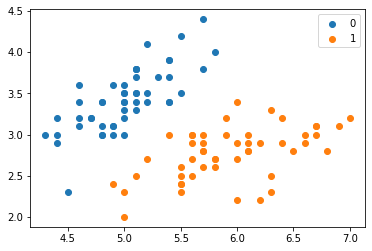

In [4]:
plt.scatter(X[:50,0],X[:50,1], label='0')
plt.scatter(X[50:,0],X[50:,1], label='1')
plt.legend()

----

### AdaBoost in Python

#### 分类问题

In [6]:
# 二类分类问题的 基学习器 G_m

def greater_than(X, feature, value):
    return np.where(X[:, feature] > value, 1, -1) 

def less_than(X, feature, value):
    return np.where(X[:, feature] < value, 1, -1)

FUNC_LIST = [greater_than, less_than]


class BiClassifer:
    def __init__(self, funcs=FUNC_LIST):# 样本权值
        self.funcs = funcs
        self.value_split = None
        self.func_i = None
        self.feature = None
    
    @staticmethod
    def error_(y_pred, y, weights):
        return np.sum(weights * (y_pred != y))
        
    def choose_best_value(self, X, y, feature):
        # 返回 最小的error, 最佳分割点 相应的func 
        value_split_list = np.sort(X[:, feature])
        value_split = (value_split_list[1:] + value_split_list[:-1]) / 2
        
        error_one_feature = np.zeros((len(value_split), 4))
        for i, value in enumerate(value_split):
            error_min = np.inf
            for j, func in enumerate(self.funcs):
                y_pred = func(X, feature, value)
                error = self.error_(y_pred, y, self.weights)
                if error < error_min:
                    error_min = error
                    error_one_feature[i,:] = [error, value, j, feature]

        min_index = np.argmin(error_one_feature[:, 0])
        return error_one_feature[min_index]
    
    def choose_best_feature(self, X, y):
        n_features = X.shape[1]
        features = np.arange(n_features)
        
        error_all_features = np.zeros((n_features, 4))
        for i in range(n_features):
            error_all_features[i, :] = self.choose_best_value(X, y, i)
        best_ = np.argmin(error_all_features[:, 0])
        return error_all_features[best_]
    
    def fit(self, X, y, weights=None):
        self.weights = weights
        if self.weights is None:
            self.weights = np.ones(X.shape[0]) / X.shape[0]
        error, value_split, func_i, feature = self.choose_best_feature(X, y)
        # print(value_split, func_i)
        self.value_split = value_split
        self.func_i = int(func_i)
        self.feature = int(feature)
        return error
    
    def predict(self, X):
        y_pred = self.funcs[self.func_i](X, self.feature, self.value_split)
        return y_pred
    
    def score(self, X, y):
        # 无权重
        return np.sum(self.predict(X) == y) / len(y)

**例8.1**

In [7]:
X = np.arange(10).reshape(10, 1)
y = np.array([1, 1, 1, -1, -1, -1, 1, 1, 1, -1])

clf = BiClassifer()
clf.fit(X, y)

0.30000000000000004

In [8]:
clf.score(X, y)

0.7

In [10]:
clf.func_i, clf.feature, clf.value_split

(1, 0, 2.5)

In [37]:
class MyAdaBoostClassifier:
    def __init__(self, n_estimators=50, base_classifier=BiClassifer, epsilon=0.05):
        self.n_estimators = n_estimators
        self.bc_ = base_classifier
        self.epsilon = epsilon  # 错误率阈值
        self.X = None
        self.y =None
        self.weights = None
        self.func_list = []  # alpha 基分类器 
    
    def Z_(self, alpha, clf):
        # 计算归一化因子 Z_m = \sum_{i=1}^N w_{mi} exp(-alpha_m y_i G_m(x_i))
        z = np.sum(self.weights * np.exp(-alpha * self.y * clf.predict(self.X)))
        return z
    
    def w_(self, alpha, clf, Z):
        # 样本权值更新 w_{m+1, i} = w_{mi} / Z exp(-alpha_m y_i G_m(x_i))
        self.weights =  self.weights / Z * np.exp(-alpha * self.y * clf.predict(self.X))
       
    def fit(self, X, y):
        self.X = X
        self.y = y
        n_sample, n_feature = X.shape
        self.weights = np.ones(n_sample) / n_sample  # 初始的权重 D1
        Z_list = []
        for i in range(self.n_estimators):
            # 1. 使用当前权值分布的训练数据集学习，得到基本分类器
            clf = self.bc_()
            # 2. 计算分类误差率
            error = clf.fit(X, y, self.weights)
            # 3. 计算系数
            alpha = 0.5 * np.log((1-error) / error)
            # 4. 更新权值
            # 归一化因子Z_m
            Z_ = self.Z_(alpha, clf)
            Z_list.append(Z_)
            # 更新w
            self.w_(alpha, clf, Z_)
            # print('em:', error)
            self.func_list.append((alpha, clf))
        error_upper_bound = np.prod(Z_list)
        print(error_upper_bound)
#             if error_upper_bound < self.epsilon:
#                 break
                
    def predict(self, X):
        clf_num = len(self.func_list)
        y_pred = np.zeros((clf_num, X.shape[0]))
        for i, (alpha, clf) in enumerate(self.func_list):
            y = alpha * clf.predict(X)
            y_pred[i, :] = y
        return np.where(np.mean(y_pred, axis=0) > 0, 1, -1)
    
    def score(self, X, y):
        return np.sum(self.predict(X) == y) / len(y) 

**例8.1**

In [38]:
X = np.arange(10).reshape(10, 1)
y = np.array([1, 1, 1, -1, -1, -1, 1, 1, 1, -1])
clf_ada = MyAdaBoostClassifier(n_estimators=3, base_classifier=BiClassifer)
clf_ada.fit(X, y)

0.5801925340982741


In [14]:
clf_ada.predict(X)

array([ 1,  1,  1, -1, -1, -1,  1,  1,  1, -1])

In [15]:
clf_ada.score(X, y)

1.0

In [39]:
X, y = create_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=12345)
clf = MyAdaBoostClassifier(n_estimators=10,    
                           base_classifier=BiClassifer)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.05576701117798486


0.9696969696969697

**鸢尾花**

In [40]:
# 100次结果
result = []
for i in range(1, 101):
    X, y = create_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    clf = MyAdaBoostClassifier(n_estimators=100, 
                               base_classifier=BiClassifer)
    clf.fit(X_train, y_train)
    r = clf.score(X_test, y_test)
    # print('{}/100 score：{}'.format(i, r))
    result.append(r)

print('average score:{:.3f}%'.format(sum(result)))

7.45511517982915e-06
1.0014492644177178e-11
2.7463996841009373e-05
6.800755804268854e-12
9.1770165133783e-12
2.044146586137567e-05
1.3371131697888055e-11
1.738596378871583e-05
1.1111738123850959e-11
1.778840947129062e-05
1.4582248339544879e-05
9.096897310546618e-06
1.575348256371242e-11
1.3561669437847925e-05
1.274604038021739e-05
1.2988981496742212e-11
8.216930940035688e-12
1.9405518849930967e-05
1.1171704726333662e-11
1.026656139731362e-05
1.213400921377893e-11
1.5885271792918895e-05
1.1487202568123142e-11
1.3747933348267912e-11
2.7246392050882355e-12
1.6898555982541126e-11
7.178619293280062e-12
5.211444748872207e-12
4.031122958942624e-06
1.1586916720062383e-05
5.351748794072299e-06
2.0429331804991544e-05
2.4970259307796897e-05
9.618278755524437e-12
8.917990171825997e-12
1.7588232498626675e-11
7.578663823593253e-12
1.7567773318048672e-05
3.4728182515157167e-12
1.4743152954295738e-11
1.231192200931244e-11
1.8670966844679502e-05
7.46780300581862e-06
1.2078102737931018e-11
5.55729517204

**[马疝病的预测](https://github.com/apachecn/AiLearning/blob/master/docs/ml/7.%E9%9B%86%E6%88%90%E6%96%B9%E6%B3%95-%E9%9A%8F%E6%9C%BA%E6%A3%AE%E6%9E%97%E5%92%8CAdaBoost.md#%E9%A1%B9%E7%9B%AE%E6%A1%88%E4%BE%8B-%E9%A9%AC%E7%96%9D%E7%97%85%E7%9A%84%E9%A2%84%E6%B5%8B)**

In [41]:
data_train = np.loadtxt('/mnt/data1/workspace/AI/data/机器学习/7.AdaBoost/horseColicTraining2.txt')
data_test = np.loadtxt("/mnt/data1/workspace/AI/data/机器学习/7.AdaBoost/horseColicTest2.txt")

In [42]:
X_train, y_train = data_train[:, :-1], data_train[:, -1]
X_test, y_test = data_test[:, :-1], data_test[:, -1]

In [43]:
y_train.shape

(299,)

In [44]:
X_test.shape

(67, 21)

In [45]:
clf = BiClassifer()
clf.fit(X_train, y_train)

0.28428093645484953

In [46]:
clf.value_split, clf.func_i, clf.feature

(3.5, 1, 9)

In [47]:
clf.score(X_test, y_test)

0.7313432835820896

In [51]:
clf = MyAdaBoostClassifier(n_estimators=300)
clf.fit(X_train, y_train)

0.3898917062947822


In [52]:
clf.score(X_train, y_train)

0.8996655518394648

In [53]:
clf.score(X_test, y_test)

0.7014925373134329

**使用sklearn**

In [54]:
from sklearn.ensemble import AdaBoostClassifier

# If None, then the base estimator is DecisionTreeClassifier(max_depth=1)
clf = AdaBoostClassifier(n_estimators=100, learning_rate=0.5)
clf.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.5, n_estimators=100)

In [55]:
clf.score(X_test, y_test)

0.7611940298507462

---
#### 回归问题

In [57]:
class Regressor:
    def __init__(self):# 样本权值
        self.value_split = None
        self.feature = None
        self.c = []
    
    @staticmethod
    def data_split(X, feature, value):
        # 使用feature特征的value取值将X切分开
        left, right = [], []
        for i in range(X.shape[0]):
            if X[i, feature] < value:
                left.append(i)
            else:
                right.append(i)
        return left, right
        
    
    def choose_best_value(self, X, y, feature):
        # 返回 最小的error, 最佳分割点 相应的func 
        value_split_list = np.sort(X[:, feature])
        value_split = (value_split_list[1:] + value_split_list[:-1]) / 2
        
        error_one_feature = np.zeros((len(value_split), 5))
        for i, value in enumerate(value_split):
            error_min = np.inf
            left, right = self.data_split(X, feature, value)
            c1 = np.mean(y[left])
            c2 = np.mean(y[right])
            # MSE误差
            error = np.sum((y[left] - c1) ** 2) + np.sum((y[right] - c2) ** 2)

            error_one_feature[i,:] = [error, feature, value, c1, c2]

        min_index = np.argmin(error_one_feature[:, 0])
        return error_one_feature[min_index]
    
    def choose_best_feature(self, X, y):
        n_features = X.shape[1]
        error_all_features = np.zeros((n_features, 5))
        for i in range(n_features):
            error_all_features[i, :] = self.choose_best_value(X, y, i)
        best_ = np.argmin(error_all_features[:, 0])
        return error_all_features[best_]
    
    def fit(self, X, y):
        error, feature, value_split, c1, c2  = self.choose_best_feature(X, y)
        # print(value_split, func_i)
        self.value_split = value_split
        self.feature = int(feature)
        self.c = [c1, c2]
        return error
    
    def predict(self, X):
        y_pred = np.where(X[:, self.feature] < self.value_split, self.c[0], self.c[1])
        return y_pred
    

**例 8.2**

In [58]:
X = np.arange(1, 11).reshape(10, 1)
y = np.array([5.56, 5.70, 5.91, 6.4, 6.8, 7.05, 8.90, 8.70, 9.00, 9.05])
clf = Regressor()
clf.fit(X, y)

1.9300083333333338

In [59]:
clf.predict(X)

array([6.2367, 6.2367, 6.2367, 6.2367, 6.2367, 6.2367, 8.9125, 8.9125,
       8.9125, 8.9125])

In [60]:
clf.value_split, clf.c, clf.feature

(6.5, [6.236666666666667, 8.912500000000001], 0)

In [65]:
# 回归问题
class MyAdaBoostRegressor:
    def __init__(self, n_estimators=20, base_learner=Regressor):
        self.clf_num = n_estimators
        self.func_list = []
        self.bl_ = base_learner
    
    def fit(self, X, y):
        self.X, self.y = X, y
        r = y
        y_pred_list = []
        for i in range(self.clf_num):
            clf = self.bl_()
            # 预测 和 目前残差越近越好
            clf.fit(X, r)
            self.func_list.append(clf)
            y_pred = clf.predict(X)
            y_pred_list.append(y_pred)
            # 当前残差
            r = y - np.sum(y_pred_list, axis=0)
        return np.sum(r ** 2)
    
    def predict(self, X):
        y_pred = np.zeros((len(self.func_list), X.shape[0]))
        for i, clf in enumerate(self.func_list):
            y = clf.predict(X)
            y_pred[i, :] = y
        return np.sum(y_pred, axis=0)
    
    # def score(self, X, y):
    #     return np.sum(self.predict(X) == y) / len(y)

In [67]:
clf = MyAdaBoostRegressor(n_estimators=6)
clf.fit(X, y)

0.17217806498628246

In [68]:
y_pred = clf.predict(X)
y_pred

array([5.63  , 5.63  , 5.8183, 6.5516, 6.8197, 6.8197, 8.9502, 8.9502,
       8.9502, 8.9502])

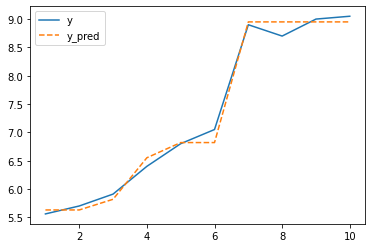

In [69]:
plt.plot(X, y, '-', label='y')
plt.plot(X, y_pred, '--', label='y_pred')
plt.legend()

----
参考代码：https://github.com/wzyonggege/statistical-learning-method

中文注释制作：机器学习初学者

微信公众号：ID:ai-start-com

配置环境：python 3.5+

代码全部测试通过。
![gongzhong](../gongzhong.jpg)